## Introduction to Convolutional Layers

The goal of this lab is to understand how to train a convolutional neural network using PyTorch. A lot of starter code will be given to you, and the student is expected to build the network details. The network should be customizable for convolutional layers of different filter sizes, kernel sizes, strides, padding and pooling layers.

The dataset we will analyze will be a small section of the nih chest xrays dataset, found here: https://www.kaggle.com/nih-chest-xrays/sample

In [1]:
#Import common dependencies
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
import datetime
import PIL, glob
import pickle
from pathlib import Path
from torch import nn
from torch.nn import init
from torch.autograd import Variable
from scipy import misc

## Dataset Selection

### First, read in the sample labels which we will treat as y classes, and split into trn and val

In [2]:
label_df = pd.read_csv('sample_labels.csv').iloc[:, :2]
label_df.index = label_df.iloc[:,0]
label_df = label_df.iloc[:,[1]]
label_df.columns = ['label']
num_rows = label_df.shape[0]
cutoff = .9
samples = np.random.rand(num_rows) < cutoff
trn, val = np.nonzero(samples)[0], np.nonzero(samples==0)[0]

### Next, map labels to unique values, and drop all uncommon labels into a 'unknown' label

In [3]:


uni_lbls = label_df['label'].value_counts().sort_values(ascending=False)
lbls = uni_lbls[uni_lbls > 10]
lbl_keys = lbls.keys()
num_keys = len(lbl_keys)
lbl_idx = np.arange(num_keys)

unk = 'unknown/uncommon'

lbl_map = {key:idx for key, idx in zip(lbl_keys, lbl_idx)}
inv_lbl_map = {idx:key for key, idx in zip(lbl_keys, lbl_idx)}

for lbl in label_df['label'].unique():
    if lbl not in lbl_map.keys():
        lbl_map[lbl] = num_keys
label_df['label_idx'] = label_df['label'].map(lbl_map)



### Load in the corresponding images, or load in the pre processed numpy array that we use to store them. Lets normalize them to [0,1]

In [4]:
my_file = Path("images.pickle")
if not my_file.is_file():
    import skimage.measure

    images = np.empty((num_rows, 256, 256))
    for idx,filename in enumerate(glob.glob('images/*')): #assuming gif
        im=misc.imread(filename)
        if im.shape[-1] < 5:
            im = im[:,:,0]
        im = skimage.measure.block_reduce(im, (4,4), np.max)
        images[idx,:,:] = im

    images = np.reshape(images, [num_rows, 1, 256, 256])
    images = images - images.min()
    images = images/images.max()
    pickle.dump(images, open('images.pickle', 'wb'))
else:
    images = pickle.load(open('images.pickle','rb'))

### Lets just visualize an image to see what we're looking at

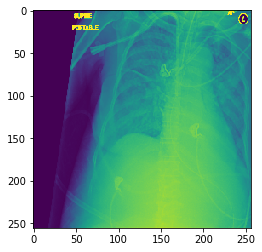

In [5]:
plt.imshow(images[0,0,:,:])

In [6]:
# Code to cleanly swap between Pytorch and Numpy.
# Makes PyTorch much more user friendly, but not widely used. 
# Base code from Andy Gan (Github BarclayII) with some minor additions

#Main adjustable flag. Enables or Disable GPU optimizations
USE_CUDA = 1

def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj

def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs

In [7]:
#Build the network in pytorch

def init_weights(module):
    #Optional: Initialize weights using Xavier Initialization 
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)

class Identity(nn.Module):
    #Identity Module
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self,input_shape, hidden_layers, num_outputs, lr = 1e-3):
        #num_inputs is the number of input feature
        #Hidden layers is a list of hidden layer sizes)
        nn.Module.__init__(self)
        self.input_shape = input_shape
        
        prev_filters = 1
        self.hidden_layers = nn.ModuleList()
        shape = input_shape
        self.trn_losses = []
        self.val_losses = []
        self.relu = nn.LeakyReLU()
        for idx, (filters, kernel_size, stride, padding, pool) in enumerate(hidden_layers):
            if pool:
                layer = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)
            else:
                layer = nn.Conv2d(in_channels = prev_filters, out_channels = filters, kernel_size = kernel_size, 
                              stride=stride, padding=padding)
                prev_filters = filters
            if idx == 0:
                self.first_layer = layer
            self.hidden_layers.append(layer)
            shape = shape // stride
        self.flat_size = prev_filters * shape * shape
        self.output_layer = nn.Linear(self.flat_size, num_outputs)
        
        self.loss_fcn = nn.CrossEntropyLoss()
            
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = lr, weight_decay = 1e-8)
        init_weights(self)
        
    def forward(self, x, y):

        x = tovar(x).float()
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        x = x.view(-1, self.flat_size)
        output = self.output_layer(x)
        return output, self.loss_fcn(output, y)


In [8]:

def train(epochs = 3, verbosity = 0, val_freq = 1):
    num_epochs = epochs
    bs = 128
    rows_trn = len(trn)
    batches_per_epoch = rows_trn // bs
    for epoch in range(num_epochs):
        # Optimize Model on mini batches
        trn_loss = []
        trn_acc = [0,0]
        order = np.arange(rows_trn)
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr*bs:(itr+1)*bs]
            if itr+1 == batches_per_epoch:
                rows = order[itr*bs:]
            samples = trn[rows]
            x, y = images[samples,:,:,:], label_df.iloc[samples, 1].as_matrix()

            y_pred, loss = model(x, tovar(y))

            # Before the backward pass, use the optimizer object to zero all of the 
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data[0]))
            if itr % 100 == 0:
                print('itr:', itr)
        if epoch % val_freq == 0:
            #Evaluate Performance on on validation set
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            samples = val
            xval, yval = images[samples,:,:,:], label_df.iloc[samples, 1].as_matrix()
            y_pred, loss = model(xval, tovar(yval))
            val_loss = tonumpy(loss.data[0])
            print( 'epoch:', epoch)
            print('train loss: ',trn_loss)
            print('val loss: ',val_loss)
            trn_loss = []
            model.val_losses.append(val_loss)
def visualize(verbosity = 0):
    #Visualize performance of training and validation throughout training
    print('Best Loss:', min(model.val_losses))
    plt.close()     
    plt.plot(model.trn_losses, label='train loss')
    plt.plot(model.val_losses, label='val loss')
    plt.legend()
    plt.title('losses')
    plt.show()

Now the code is done so lets test our model with different parameter settings!

In [9]:
num_epochs = 6
verb = 0
#As in model, hidden layers have order (filters, kernel_size, stride, padding, pool)
#filters is the number of filters in the layer,
#the layer has kernels of shape kernel_size x kernel_size,
#stride is the stride length in each direction
#padding is the padding width in each direction. consider (kernel_size -1)/2
#pool is an indicator for pooling. 0 for convolution, 1 for pooling.
hidden_layers = [
    [32, 5, 2, 2, 0],
    [16, 3, 2, 1, 0],
    [16, 3, 1, 1, 0],
    [0, 3, 2, 1, 1],
    [16, 3, 1, 1, 0],
    [0, 3, 2, 1, 1],
    [16, 3, 1, 1, 0],
    [16, 3, 2, 1, 0],
    [16, 3, 1, 1, 0],
]

itr: 0
epoch: 0
train loss:  2.54941413341
val loss:  1.9344695806503296
itr: 0
epoch: 1
train loss:  2.05196302365
val loss:  1.9117622375488281
itr: 0
epoch: 2
train loss:  2.04905902728
val loss:  1.918596863746643
itr: 0
epoch: 3
train loss:  2.03907788717
val loss:  1.9087804555892944
itr: 0
epoch: 4
train loss:  2.03754814466
val loss:  1.9021364450454712
itr: 0
epoch: 5
train loss:  2.04186993073
val loss:  1.9116451740264893
itr: 0
epoch: 6
train loss:  2.03615692029
val loss:  1.9209768772125244
itr: 0
epoch: 7
train loss:  2.03757321529
val loss:  1.9114649295806885
itr: 0
epoch: 8
train loss:  2.03111799252
val loss:  1.9170080423355103
itr: 0
epoch: 9
train loss:  2.03722719657
val loss:  1.9062113761901855
Best Loss: 1.9021364450454712


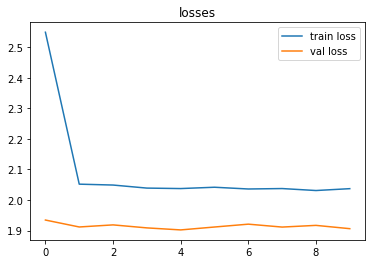

In [10]:

model = cuda(Model(images.shape[2], hidden_layers = hidden_layers, num_outputs= int(num_keys + 1)))
x = train(epochs = num_epochs, verbosity = verb)
visualize()

## Now lets visualize the types of features the early layers of the model has learned

In [11]:
weights = tonumpy(model.first_layer.weight.data)

In [12]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [13]:
#Code adapted from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, rows = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## With a normal ML dataset we should see more reasonable learned features, I don't see the model learning much with our tiny training efforts though.

In [14]:
show_images([weight[0] for weight in weights], rows = 4)